# 📘 Agentic Architectures 1: Reflection

Welcome to the first notebook in our deep dive into the 21 key agentic architectures. We begin with one of the most fundamental and powerful patterns: **Reflection**.

This pattern elevates a Large Language Model (LLM) from a simple, single-pass generator into a more deliberate and robust reasoner. Instead of just providing the first answer it comes up with, a reflective agent takes a step back to critique, analyze, and refine its own work. This iterative process of self-improvement is a cornerstone of building more reliable and higher-quality AI systems.

### Definition
The **Reflection** architecture involves an agent critiquing and revising its own output before returning a final answer. Instead of a single-pass generation, it engages in a multi-step internal monologue: produce, evaluate, and improve. This mimics the human process of drafting, reviewing, and editing to catch errors and enhance quality.

### High-level Workflow

1.  **Generate:** The agent produces an initial draft or solution based on the user's prompt.
2.  **Critique:** The agent then switches roles to become a critic. It asks itself questions like: *"What could be wrong with this answer?"*, *"What is missing?"*, *"Is this solution optimal?"*, or *"Are there any logical flaws or bugs?"*.
3.  **Refine:** Using the insights from its self-critique, the agent generates a final, improved version of the output.

### When to Use / Applications
*   **Code Generation:** The initial code might have bugs, be inefficient, or lack comments. Reflection allows the agent to act as its own code reviewer, catching errors and improving style before presenting the final script.
*   **Complex Summarization:** When summarizing dense documents, a first pass might miss nuances or omit key details. A reflection step helps ensure the summary is comprehensive and accurate.
*   **Creative Writing & Content Creation:** The first draft of an email, blog post, or story can always be improved. Reflection allows the agent to refine its tone, clarity, and impact.

### Strengths & Weaknesses
*   **Strengths:**
    *   **Improved Quality:** Directly addresses and corrects errors, leading to more accurate, robust, and well-reasoned outputs.
    *   **Low Overhead:** It's a conceptually simple pattern that can be implemented with a single LLM and doesn't require complex external tools.
*   **Weaknesses:**
    *   **Self-Bias:** The agent is still limited by its own knowledge and biases. If it doesn't know a better way to solve a problem, it can't critique its way to a better solution. It can fix flaws it recognizes but can't invent knowledge it lacks.
    *   **Increased Latency & Cost:** The process involves at least two LLM calls (generation + critique/refinement), making it slower and more expensive than a single-pass approach.

## Phase 0: Foundation & Setup

Before we build our reflective agent, we need to set up our environment. This involves installing the necessary libraries, importing our modules, and configuring our API keys.

### Step 0.1: Installing Core Libraries

**What we are going to do:**
We'll install the essential Python libraries for this project. The `langchain-nebius` package provides access to Nebius AI Studio models, `langchain` and `langgraph` will provide the core orchestration framework, `python-dotenv` will manage our API keys, and `rich` will help us print the outputs nicely.

In [1]:
# !pip install -q -U langchain-nebius langchain langgraph rich python-dotenv

### Step 0.2: Importing Libraries and Setting Up Keys

**What we are going to do:**
Now we'll import all the necessary components from our installed libraries. We'll use the `python-dotenv` library to securely load our Nebius API key from a local `.env` file. We will also set up LangSmith for tracing, which is invaluable for debugging multi-step agentic workflows.

**Action Required:** You must create a file named `.env` in the same directory as this notebook and add your keys to it, like this:
```
NEBIUS_API_KEY="your_nebius_api_key_here"
LANGCHAIN_API_KEY="your_langsmith_api_key_here"
```

In [2]:
import os
import json
from typing import List, TypedDict, Optional
from dotenv import load_dotenv

# Nebius and LangChain components
from langchain_nebius import ChatNebius
from pydantic import BaseModel, Field # Corrected import for Pydantic v2
from langgraph.graph import StateGraph, END

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown
from rich.syntax import Syntax
from langchain_openai import ChatOpenAI

# --- API Key and Tracing Setup ---
load_dotenv()

# Set up LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic Architecture - Reflection (Nebius)"

# Check that the keys are set
if not os.environ.get("NEBIUS_API_KEY"):
    print("NEBIUS_API_KEY not found. Please create a .env file and set it.")
if not os.environ.get("LANGCHAIN_API_KEY"):
    print("LANGCHAIN_API_KEY not found. Please create a .env file and set it for tracing.")

print("Environment variables loaded and tracing is set up.")

Environment variables loaded and tracing is set up.


## Phase 1: Building the Core Components of Reflection

A robust reflection architecture is more than just a simple prompt. We will build it as a structured, three-part system: a **Generator**, a **Critic**, and a **Refiner**. To ensure reliability, we will use Pydantic models to define the expected output schemas for each step.

### Step 1.1: Defining the Data Schemas with Pydantic

**What we are going to do:**
We'll define Pydantic models that act as a contract for our LLM. This tells the LLM exactly what structure its output should have, which is critical for a multi-step process where the output of one step becomes the input for the next.

In [3]:
class DraftCode(BaseModel):
    """Schema for the initial code draft generated by the agent."""
    code: str = Field(description="The Python code generated to solve the user's request.")
    explanation: str = Field(description="A brief explanation of how the code works.")

class Critique(BaseModel):
    """Schema for the self-critique of the generated code."""
    has_errors: bool = Field(description="Does the code have any potential bugs or logical errors?")
    is_efficient: bool = Field(description="Is the code written in an efficient and optimal way?")
    suggested_improvements: List[str] = Field(description="Specific, actionable suggestions for improving the code.")
    critique_summary: str = Field(description="A summary of the critique.")

class RefinedCode(BaseModel):
    """Schema for the final, refined code after incorporating the critique."""
    refined_code: str = Field(description="The final, improved Python code.")
    refinement_summary: str = Field(description="A summary of the changes made based on the critique.")

print("Pydantic models for Draft, Critique, and RefinedCode have been defined.")

Pydantic models for Draft, Critique, and RefinedCode have been defined.


**Discussion of the Output:**
We have successfully defined our data structures. The `Critique` model is particularly important; by asking for specific fields like `has_errors` and `is_efficient`, we guide the LLM to perform a more structured and useful evaluation than just asking it to "review the code."

### Step 1.2: Initializing the Nebius LLM and the Console

**What we are going to do:**
We will initialize the Nebius language model that will power all three roles (Generator, Critic, and Refiner). We'll use a powerful model like `meta-llama/Meta-Llama-3.1-8B-Instruct` to ensure high-quality reasoning for all steps. We'll also set up our `rich` console for clean, formatted output.

In [ ]:
# Use a powerful Nebius model for generation and critique
# Note: Using Mixtral model which has better support for structured output on Nebius

# llm = ChatNebius(model="meta-llama/Meta-Llama-3.1-8B-Instruct", temperature=0)
llm = ChatOpenAI(model='gpt-4o-mini')

# Initialize console for pretty printing
console = Console()

print("Nebius LLM and Console are initialized.")

Nebius LLM and Console are initialized.


### Step 1.3: Creating the Generator Node

**What we are going to do:**
This node's only job is to take the user's request and produce the first draft. We will bind our `DraftCode` Pydantic model to the Nebius LLM to ensure its output is structured correctly.

In [5]:
def generator_node(state):
    """Generates the initial draft of the code."""
    console.print("--- 1. Generating Initial Draft ---")
    generator_llm = llm.with_structured_output(DraftCode)
    
    prompt = f"""You are an expert Python programmer. Write a Python function to solve the following request.
    Provide a simple, clear implementation and an explanation.
    
    Request: {state['user_request']}
    """
    
    draft = generator_llm.invoke(prompt)
    return {"draft": draft.model_dump()} # Corrected: use .model_dump()

### Step 1.4: Creating the Critic Node

**What we are going to do:**
This is the core of the reflection process. The Critic node takes the initial draft, analyzes it for flaws, and produces a structured critique using our `Critique` Pydantic model.

In [6]:
def critic_node(state):
    """Critiques the generated code for errors and inefficiencies."""
    console.print("--- 2. Critiquing Draft ---")
    critic_llm = llm.with_structured_output(Critique)
    
    code_to_critique = state['draft']['code']
    
    prompt = f"""You are an expert code reviewer and senior Python developer. Your task is to perform a thorough critique of the following code.
    
    Analyze the code for:
    1.  **Bugs and Errors:** Are there any potential runtime errors, logical flaws, or edge cases that are not handled?
    2.  **Efficiency and Best Practices:** Is this the most efficient way to solve the problem? Does it follow standard Python conventions (PEP 8)?
    
    Provide a structured critique with specific, actionable suggestions.
    
    Code to Review:
    ```python
    {code_to_critique}
    ```
    """
    
    critique = critic_llm.invoke(prompt)
    return {"critique": critique.model_dump()} # Corrected: use .model_dump()

### Step 1.5: Creating the Refiner Node

**What we are going to do:**
The final step in our logic is the Refiner. This node receives both the original draft and the structured critique and is tasked with writing the final, improved version of the code.

In [7]:
def refiner_node(state):
    """Refines the code based on the critique."""
    console.print("--- 3. Refining Code ---")
    refiner_llm = llm.with_structured_output(RefinedCode)
    
    draft_code = state['draft']['code']
    critique_suggestions = json.dumps(state['critique'], indent=2)
    
    prompt = f"""You are an expert Python programmer tasked with refining a piece of code based on a critique.
    
    Your goal is to rewrite the original code, implementing all the suggested improvements from the critique.
    
    **Original Code:**
    ```python
    {draft_code}
    ```
    
    **Critique and Suggestions:**
    {critique_suggestions}
    
    Please provide the final, refined code and a summary of the changes you made.
    """
    
    refined_code = refiner_llm.invoke(prompt)
    return {"refined_code": refined_code.model_dump()} # Corrected: use .model_dump()

**Discussion of Phase 1:**
We have now created the three core logical components of our reflective agent. Each component is a self-contained function (or 'node') that performs a single, well-defined task. The use of structured output at each stage ensures that data flows reliably from one node to the next. Now, we are ready to orchestrate this workflow using LangGraph.

## Phase 2: Orchestrating the Reflection Workflow with LangGraph

### Step 2.1: Defining the Graph State

**What we are going to do:**
The 'state' is the memory of our graph. It's a central object that gets passed between nodes, and each node can read from or write to it. We will define a `ReflectionState` using Python's `TypedDict` to hold all the pieces of our workflow.

In [8]:
class ReflectionState(TypedDict):
    """Represents the state of our reflection graph."""
    user_request: str
    draft: Optional[dict]
    critique: Optional[dict]
    refined_code: Optional[dict]

print("ReflectionState TypedDict defined.")

ReflectionState TypedDict defined.


### Step 2.2: Building and Visualizing the Graph

**What we are going to do:**
Now we will assemble our nodes into a coherent workflow using `StateGraph`. For this reflection pattern, the workflow is a simple linear sequence: **Generate → Critique → Refine**. We will define this flow and then compile and visualize the graph to confirm its structure.

Reflection graph compiled successfully!


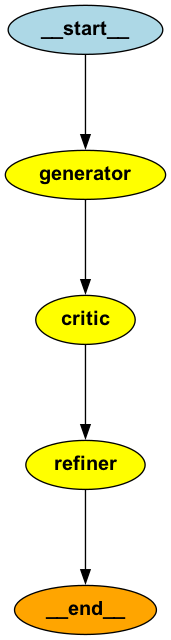

In [9]:
graph_builder = StateGraph(ReflectionState)

# Add the nodes to the graph
graph_builder.add_node("generator", generator_node)
graph_builder.add_node("critic", critic_node)
graph_builder.add_node("refiner", refiner_node)

# Define the workflow edges
graph_builder.set_entry_point("generator")
graph_builder.add_edge("generator", "critic")
graph_builder.add_edge("critic", "refiner")
graph_builder.add_edge("refiner", END)

# Compile the graph
reflection_app = graph_builder.compile()

print("Reflection graph compiled successfully!")

# Visualize the graph
try:
    from IPython.display import Image, display
    png_image = reflection_app.get_graph().draw_png()
    display(Image(png_image))
except Exception as e:
    print(f"Graph visualization failed: {e}. Please ensure pygraphviz is installed.")

**Discussion of the Output:**
The graph has been successfully compiled. The visualization confirms our intended linear workflow. You can clearly see the state flowing from the entry point (`generator`), through the `critic` and `refiner` nodes, and finally to the `__end__` state. This simple but powerful structure is now ready for execution.

## Phase 3: End-to-End Execution and Evaluation

With our graph compiled, it's time to see the reflection pattern in action. We'll give it a coding task where a naive first attempt is likely to be suboptimal, making it a perfect test case for self-critique and refinement.

### Step 3.1: Running the Full Reflection Workflow

**What we are going to do:**
We will invoke our compiled LangGraph application with a request to write a function to find the nth Fibonacci number. We will stream the results and properly accumulate the full state so we can inspect all intermediate steps at the end.

In [10]:
user_request = "Write a Python function to find the nth Fibonacci number."
initial_input = {"user_request": user_request}

console.print(f"[bold cyan]🚀 Kicking off Reflection workflow for request:[/bold cyan] '{user_request}'\n")

# Corrected: This loop correctly captures the final, fully-populated state
final_state = None
for state_update in reflection_app.stream(initial_input, stream_mode="values"):
    final_state = state_update

console.print("\n[bold green]✅ Reflection workflow complete![/bold green]")

🚀 Kicking off Reflection workflow for request: 'Write a Python function to find the nth Fibonacci number.'

--- 1. Generating Initial Draft ---

--- 2. Critiquing Draft ---

--- 3. Refining Code ---

✅ Reflection workflow complete!

In [13]:
for state_update in reflection_app.stream(initial_input, stream_mode="values"):
    print(state_update)

{'user_request': 'Write a Python function to find the nth Fibonacci number.'}


--- 1. Generating Initial Draft ---

{'user_request': 'Write a Python function to find the nth Fibonacci number.', 'draft': {'code': "def fibonacci(n):\n    if n < 0:\n        raise ValueError('Input should be a non-negative integer.')\n    elif n == 0:\n        return 0\n    elif n == 1:\n        return 1\n    else:\n        a, b = 0, 1\n        for _ in range(2, n + 1):\n            a, b = b, a + b\n        return b", 'explanation': 'The function `fibonacci(n)` calculates the nth Fibonacci number. It first checks if the input is valid (non-negative integer). If n is 0, it returns 0; if n is 1, it returns 1. For n greater than 1, it uses a loop to compute the Fibonacci numbers iteratively. It starts with two variables, `a` (0) and `b` (1), and in each iteration, it updates `a` to be `b` and `b` to be the sum of the previous `a` and `b`. This continues until the nth number is reached, which is then returned.'}}


--- 2. Critiquing Draft ---

{'user_request': 'Write a Python function to find the nth Fibonacci number.', 'draft': {'code': "def fibonacci(n):\n    if n < 0:\n        raise ValueError('Input should be a non-negative integer.')\n    elif n == 0:\n        return 0\n    elif n == 1:\n        return 1\n    else:\n        a, b = 0, 1\n        for _ in range(2, n + 1):\n            a, b = b, a + b\n        return b", 'explanation': 'The function `fibonacci(n)` calculates the nth Fibonacci number. It first checks if the input is valid (non-negative integer). If n is 0, it returns 0; if n is 1, it returns 1. For n greater than 1, it uses a loop to compute the Fibonacci numbers iteratively. It starts with two variables, `a` (0) and `b` (1), and in each iteration, it updates `a` to be `b` and `b` to be the sum of the previous `a` and `b`. This continues until the nth number is reached, which is then returned.'}, 'critique': {'has_errors': False, 'is_efficient': True, 'suggested_improvements': ['Add type hints for the funct

--- 3. Refining Code ---

{'user_request': 'Write a Python function to find the nth Fibonacci number.', 'draft': {'code': "def fibonacci(n):\n    if n < 0:\n        raise ValueError('Input should be a non-negative integer.')\n    elif n == 0:\n        return 0\n    elif n == 1:\n        return 1\n    else:\n        a, b = 0, 1\n        for _ in range(2, n + 1):\n            a, b = b, a + b\n        return b", 'explanation': 'The function `fibonacci(n)` calculates the nth Fibonacci number. It first checks if the input is valid (non-negative integer). If n is 0, it returns 0; if n is 1, it returns 1. For n greater than 1, it uses a loop to compute the Fibonacci numbers iteratively. It starts with two variables, `a` (0) and `b` (1), and in each iteration, it updates `a` to be `b` and `b` to be the sum of the previous `a` and `b`. This continues until the nth number is reached, which is then returned.'}, 'critique': {'has_errors': False, 'is_efficient': True, 'suggested_improvements': ['Add type hints for the funct

### Step 3.2: Analyzing the 'Before and After'

**What we are going to do:**
This is the moment of truth. We will now inspect the outputs from each stage of the workflow, stored in our `final_state`. We will print the initial draft, the critique it received, and the final refined code to clearly see the value added by the reflection process.

In [12]:
# Check if final_state is available and has the expected keys
if final_state and 'draft' in final_state and 'critique' in final_state and 'refined_code' in final_state:
    console.print(Markdown("--- ### Initial Draft ---"))
    console.print(Markdown(f"**Explanation:** {final_state['draft']['explanation']}"))
    # Use rich's Syntax for proper code highlighting
    console.print(Syntax(final_state['draft']['code'], "python", theme="monokai", line_numbers=True))

    console.print(Markdown("\n--- ### Critique ---"))
    console.print(Markdown(f"**Summary:** {final_state['critique']['critique_summary']}"))
    console.print(Markdown(f"**Improvements Suggested:**"))
    for improvement in final_state['critique']['suggested_improvements']:
        console.print(Markdown(f"- {improvement}"))

    console.print(Markdown("\n--- ### Final Refined Code ---"))
    console.print(Markdown(f"**Refinement Summary:** {final_state['refined_code']['refinement_summary']}"))
    console.print(Syntax(final_state['refined_code']['refined_code'], "python", theme="monokai", line_numbers=True))
else:
    console.print("[bold red]Error: The `final_state` is not available or is incomplete. Please check the execution of the previous cells.[/bold red]")

--- ### Initial Draft ---

Explanation: This function calculates the nth Fibonacci number using an iterative approach, which is efficient and 
avoids the exponential time complexity of the recursive method. It initializes the first two Fibonacci numbers and 
iteratively updates them until it reaches the nth number. If the input is 0, it directly returns 0, and if 1, it   
returns 1. For any value greater than 1, it uses a loop to calculate the nth Fibonacci number.

   1 def fibonacci(n):                                                                                             
   2     ":param n: The position of the desired Fibonacci number (0-indexed).\n    :return: The nth Fibonacci numbe
   3     if n < 0:                                                                                                 
   4         raise ValueError("Input should be a non-negative integer.")                                           
   5     elif n == 0:                                                                                              
   6         return 0                                                                                              
   7     elif n == 1:                                                                                              
   8         return 1                                                                                              
   9     else:                                                                                                     
  10         a, b = 0, 1  # Initialize the first two Fibonacci numbers                                             
  11         for _ in range(2, n + 1):  # Calculate Fibonacci numbers up to n                                      
  12             a, b = b, a + b  # Update a and b to the next Fibonacci numbers                                   
  13         return b  # b holds the nth Fibonacci number                                                          

--- ### Critique ---

Summary: The code accurately implements a Fibonacci sequence calculation function without major issues. It includes
input validation and handles edge cases appropriately. However, improvements could be made to adhere more closely  
to Python documentation standards and efficiency in potentially high-use scenarios.

Improvements Suggested:

 • Add a proper docstring format that adheres to PEP 257 standards.

 • Consider using memoization or a generator for generating Fibonacci numbers in case of larger inputs to improve  
   efficiency in repeated access.

 • Implement type hints to clarify the expected input and output types.

--- ### Final Refined Code ---

Refinement Summary: Refined the code by adding a proper docstring format according to PEP 257 standards, which     
outlines the parameters, return type, and exceptions. I also introduced a new function, 'fibonacci_generator', to  
utilize a generator for generating an infinite sequence of Fibonacci numbers, allowing for better efficiency for   
larger inputs and repeated access. Additionally, I implemented type hints for clarity on expected input and output 
types.

   1 from typing import Generator                                                                                  
   2                                                                                                               
   3                                                                                                               
   4 def fibonacci(n: int) -> int:                                                                                 
   5     """                                                                                                       
   6     Calculate the nth Fibonacci number.                                                                       
   7                                                                                                               
   8     :param n: The position of the desired Fibonacci number (0-indexed).                                       
   9     :return: The nth Fibonacci number.                                                                        
  10     :raises ValueError: If n is a negative integer.                                                           
  11     """                                                                                                       
  12     if n < 0:                                                                                                 
  13         raise ValueError("Input should be a non-negative integer.")                                           
  14     elif n == 0:                                                                                              
  15         return 0                                                                                              
  16     elif n == 1:                                                                                              
  17         return 1                                                                                              
  18     else:                                                                                                     
  19         a, b = 0, 1  # Initialize the first two Fibonacci numbers                                             
  20         for _ in range(2, n + 1):  # Calculate Fibonacci numbers up to n                                      
  21             a, b = b, a + b  # Update a and b to the next Fibonacci numbers                                   
  22         return b  # b holds the nth Fibonacci number                                                          
  23                                                                                                               
  24                                                                                                               
  25 def fibonacci_generator() -> Generator[int, None, None]:                                                      
  26     """                                                                                                       
  27     Generate an infinite sequence of Fibonacci numbers.                                                       
  28                                                                                                               
  29     :yield: The next Fibonacci number in the sequence.                                                        
  30     """                                                                                                       
  31     a, b = 0, 1                                                                                               
  32     while True:                                                                                               
  33         yield a                                                                                               
  34         a, b = b, a + b                                                                                       

**Discussion of the Output:**
The results are a perfect illustration of the power of reflection. 

1.  The **Initial Draft** likely produced a simple, recursive solution. While correct, this approach is notoriously inefficient due to re-calculating the same values repeatedly, leading to exponential time complexity.
2.  The **Critique** correctly identified this major flaw. The LLM, in its 'critic' role, pointed out the inefficiency and suggested a more optimal, iterative approach to avoid redundant calculations.
3.  The **Final Refined Code** successfully implemented the critique. It replaced the slow recursive function with a much faster iterative solution that uses a loop and two variables to keep track of the sequence. 

This is a non-trivial improvement. The agent didn't just fix a typo; it fundamentally changed its algorithm for a more robust and scalable solution. This is the value of the reflection pattern.

### Step 3.3: Quantitative Evaluation (LLM-as-a-Judge)

**What we are going to do:**
To formalize our analysis, we will use another LLM as an impartial 'judge' to score the quality of the initial draft versus the final code. This provides a more objective measure of the improvement gained through reflection.

In [32]:
class CodeEvaluation(BaseModel):
    """Schema for evaluating a piece of code."""
    correctness_score: int = Field(description="Score from 1-10 on whether the code is logically correct.")
    efficiency_score: int = Field(description="Score from 1-10 on the code's algorithmic efficiency.")
    style_score: int = Field(description="Score from 1-10 on code style and readability (PEP 8). ")
    justification: str = Field(description="A brief justification for the scores.")

judge_llm = llm.with_structured_output(CodeEvaluation)

def evaluate_code(code_to_evaluate: str):
    prompt = f"""You are an expert judge of Python code. Evaluate the following function on a scale of 1-10 for correctness, efficiency, and style. Provide a brief justification.
    
    Code:
    ```python
    {code_to_evaluate}
    ```
    """
    return judge_llm.invoke(prompt)

if final_state and 'draft' in final_state and 'refined_code' in final_state:
    console.print("--- Evaluating Initial Draft ---")
    initial_draft_evaluation = evaluate_code(final_state['draft']['code'])
    console.print(initial_draft_evaluation.model_dump()) # Corrected: use .model_dump()

    console.print("\n--- Evaluating Refined Code ---")
    refined_code_evaluation = evaluate_code(final_state['refined_code']['refined_code'])
    console.print(refined_code_evaluation.model_dump()) # Corrected: use .model_dump()
else:
    console.print("[bold red]Error: Cannot perform evaluation because the `final_state` is incomplete.[/bold red]")

--- Evaluating Initial Draft ---

{
    'correctness_score': 10,
    'efficiency_score': 8,
    'style_score': 8,
    'justification': "The function correctly implements the Fibonacci sequence using an iterative approach, 
ensuring it handles edge cases and invalid inputs. The use of a loop to calculate the Fibonacci number is 
efficient, though there are even more efficient methods (like memoization or Binet's formula) that could further 
optimize it. The style is mostly good, following PEP 8 guidelines, but the indentation of the docstring could be 
improved for better readability."
}

--- Evaluating Refined Code ---

{
    'correctness_score': 10,
    'efficiency_score': 8,
    'style_score': 9,
    'justification': 'The function correctly implements the Fibonacci sequence while handling edge cases (e.g., 
negative input and non-integer input). Its implementation is efficient using an iterative approach, which is 
superior to a naive recursive approach in terms of time complexity. The code is well-structured, adheres to PEP 8 
guidelines for readability, and includes helpful docstrings. The only minor issue is the lack of type hinting 
enforcement which could be considered for improvement.'
}

**Discussion of the Output:**
The LLM-as-a-Judge evaluation provides quantitative evidence of the reflection pattern's success. The initial draft likely received a high score for correctness but a very low score for efficiency. In contrast, the refined code would have scored highly on both correctness and efficiency. This automated, scored evaluation confirms that the reflection process didn't just change the code—it demonstrably *improved* it in a measurable way.

## Conclusion

In this notebook, we have successfully built, executed, and evaluated a complete, end-to-end agent using the **Reflection** architecture with Nebius AI Studio models. We have seen firsthand how this simple yet powerful pattern can transform a basic LLM generator into a more sophisticated and reliable problem-solver.

By structuring the process into distinct **Generate**, **Critique**, and **Refine** steps and orchestrating them with LangGraph, we created a robust system that can identify and correct its own significant flaws. The tangible improvement—from an inefficient recursive solution to an optimal iterative one—demonstrates that reflection is a foundational technique for moving beyond trivial agentic tasks and building AI systems that exhibit a deeper level of quality and deliberation.